In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt 

from urllib.request import urlretrieve
import sys, os, glob
from scipy import misc

import numpy as np
import imageio
from tensorflow.keras.utils import plot_model


In [2]:
urlretrieve('https://github.com/iamcal/emoji-data/archive/master.zip','emoji.zip')
!unzip -q emoji.zip

In [3]:
files = glob.glob('emoji-data-master/*-64/*')
all_imgs = [imageio.imread(file) for file in files]
X_train = np.stack([im for im in all_imgs if im.shape==(64,64,4)])
X_train = X_train / 127.5 - 1.

In [4]:
img_rows = 64
img_cols = 64
channels = 4
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

optimizer = Adam(0.0002, 0.5)


discriminator = Sequential()
layer_sizes = [32, 64, 128, 256]

for i, layer_size in enumerate(layer_sizes):
    kwargs = {'input_shape': img_shape} if i==0 else {}
    discriminator.add(Conv2D(layer_size, (4, 4), strides=2, padding='same', **kwargs))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = Sequential()
layer_sizes = [64, 32]

generator.add(Dense(64 * 16 * 16, activation="relu", input_dim=latent_dim))
generator.add(Reshape((16, 16, 64)))

for layer_size in layer_sizes:
#     generator.add(UpSampling2D())
#     generator.add(Conv2D(layer_size, kernel_size=3, padding="same"))
    generator.add(Conv2DTranspose(layer_size, kernel_size=3, strides=2, padding='same'))

    generator.add(BatchNormalization(momentum=0.8))
    generator.add(Activation("relu"))

generator.add(Conv2D(channels, kernel_size=3, padding="same"))
generator.add(Activation("tanh")) 

z = Input(shape=(latent_dim,))
img = generator(z)

discriminator.trainable = False
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


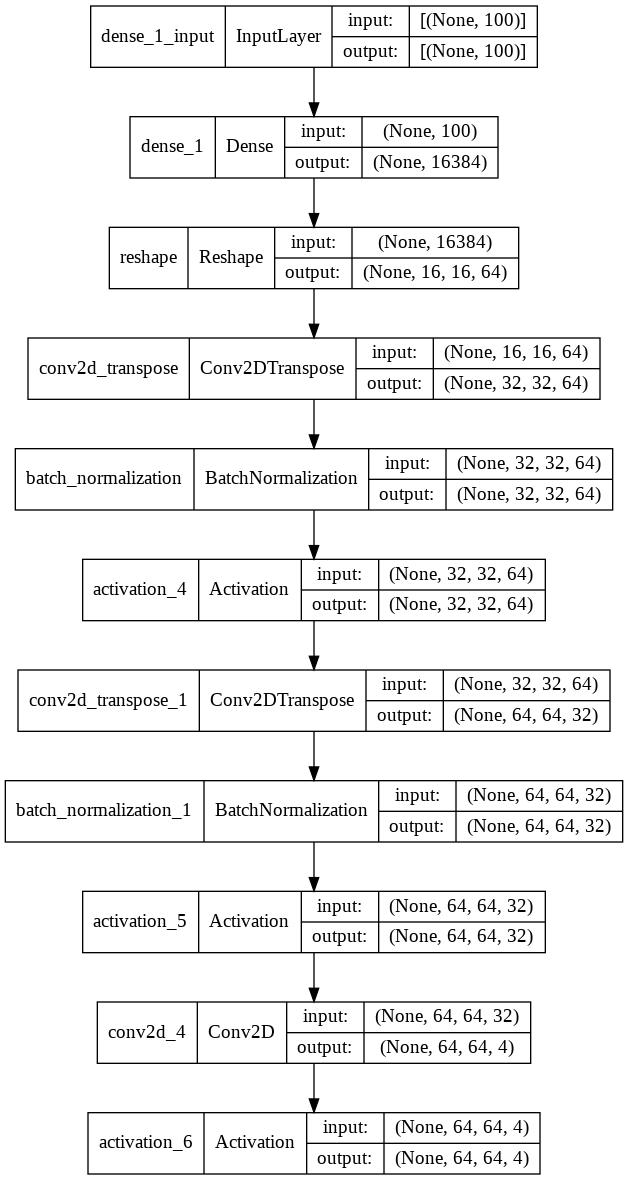

In [5]:
plot_model(generator, show_shapes=True)

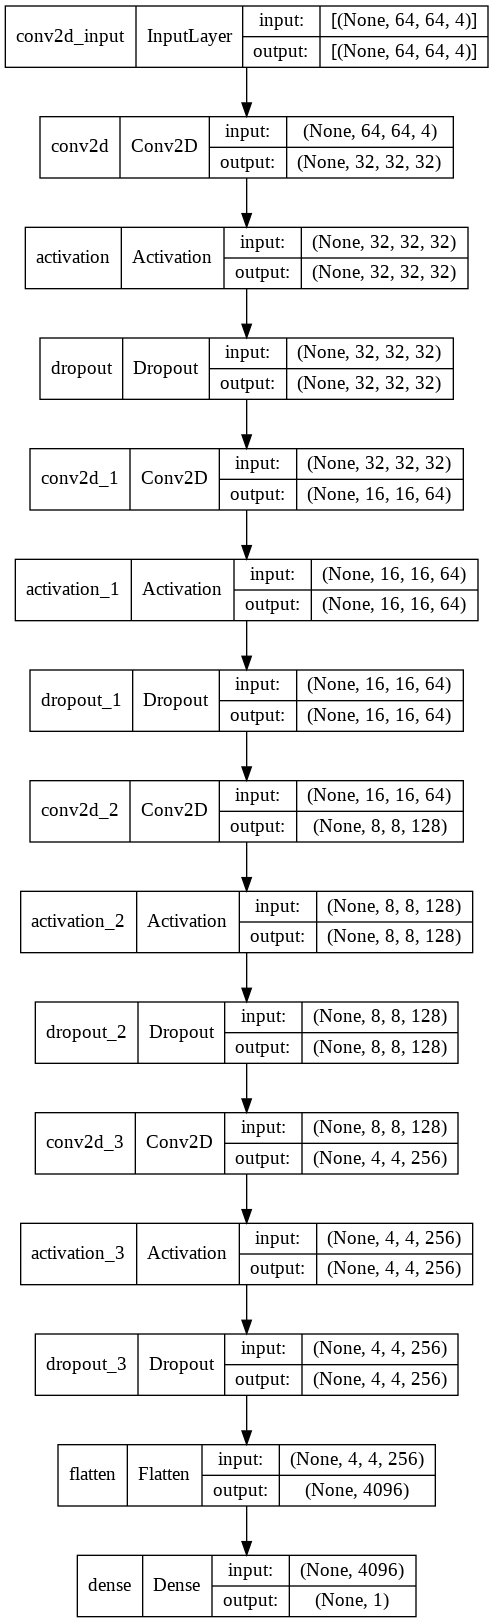

In [6]:
plot_model(discriminator, show_shapes=True)

500 [D loss: 0.3623000979423523, acc.: 84.38] [G loss: 2.191471576690674]


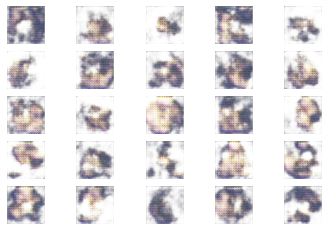

1000 [D loss: 0.4600520431995392, acc.: 87.50] [G loss: 0.9898508787155151]


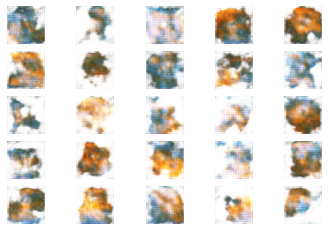

1500 [D loss: 0.3816334903240204, acc.: 85.94] [G loss: 1.6645280122756958]


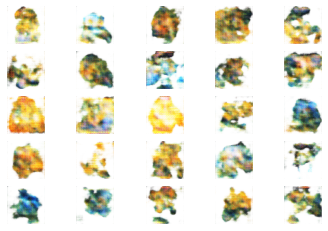

2000 [D loss: 0.4343747943639755, acc.: 78.12] [G loss: 1.7019248008728027]


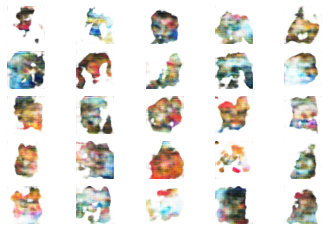

2500 [D loss: 0.211847223341465, acc.: 90.62] [G loss: 2.214235305786133]


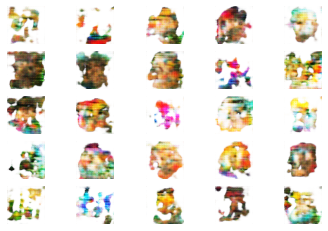

3000 [D loss: 0.49803562462329865, acc.: 73.44] [G loss: 2.016204595565796]


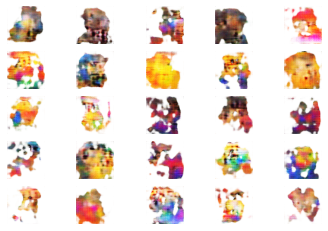

3500 [D loss: 0.2906607836484909, acc.: 87.50] [G loss: 3.267545700073242]


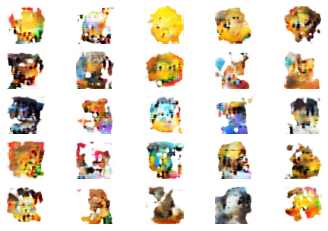

4000 [D loss: 0.06805544719099998, acc.: 96.88] [G loss: 3.50954008102417]


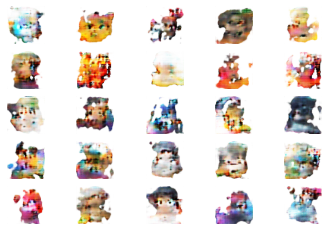

4500 [D loss: 0.05049598962068558, acc.: 98.44] [G loss: 3.473353385925293]


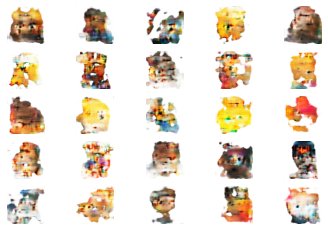

5000 [D loss: 0.1738681197166443, acc.: 93.75] [G loss: 4.264284133911133]


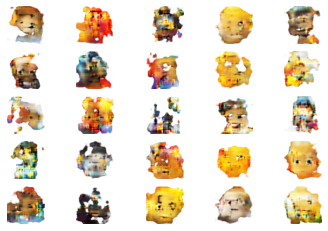

In [7]:
batch_size=32
sample_interval=500
epochs=5000

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

def sample_images(n_rows=5, n_cols=5): 
    noise = np.random.normal(0, 1, (n_rows * n_cols, latent_dim))
    images = generator.predict(noise)/2.0 + 0.5
    fig, axs = plt.subplots(n_rows, n_cols)
    for i,ax in enumerate(fig.axes):
        ax.imshow(images[i,:,:,:])
        ax.axis('off')
    plt.show()
    return fig

gs_loss = []
ds_loss = []

for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    ds_loss.append(d_loss[0])

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, valid)
    
    gs_loss.append(g_loss)

    if (epoch + 1) % sample_interval == 0:
      print(f'{epoch+1} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]:.2f}] [G loss: {g_loss}]')
      sample_images()

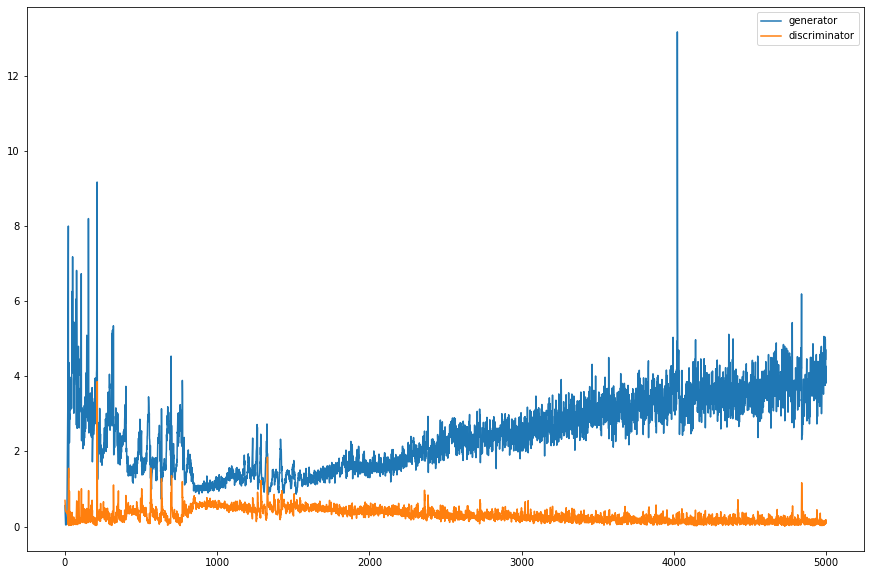

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(gs_loss, label='generator')
plt.plot(ds_loss, label='discriminator')
plt.legend()